# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a network based on Conv1D and Conv2D layers.

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet sequence, i.e. a list of particles. Foe each particle, the four-momentum coordinates are given as features.
For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf and https://arxiv.org/pdf/1908.05318.pdf.

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
! git clone https://github.com/pierinim/tutorials.git
inputDir = "tutorials/Data/JetDataset"
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (253/253), done.
^Cceiving objects:  13% (58/442), 13.68 MiB | 479.00 KiB/s    


In [10]:
# if not running on Colab
!ls ../../Data/JetDataset/
inputDir = "../../Data/JetDataset/"

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [18]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
print(target.shape, jetList.shape)
print(f.get("particleFeatureNames")[:])

Appending ../../Data/JetDataset//jetImage_7_100p_30000_40000.h5
Appending ../../Data/JetDataset//jetImage_7_100p_60000_70000.h5
Appending ../../Data/JetDataset//jetImage_7_100p_50000_60000.h5
Appending ../../Data/JetDataset//jetImage_7_100p_10000_20000.h5
Appending ../../Data/JetDataset//jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)
[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


The dataset consists of 50000 with up to 100 particles in each jet.  For each particle, 16 features are given (see printout)

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


In [24]:
# reshape to include channel
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

# Building the Conv1D model

The model consists of a first step (technically a Conv2D, but practically a Conv1D) that takes the 16 per-particle features as input and create 10 outputs. This gives 10 chains of 100 elements, which are then processed by Conv1D filters.

In [64]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Reshape, Flatten
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [65]:
featureArrayLength = (X_train.shape[1],X_train.shape[2], 1)
dropoutRate = 0.25

In [66]:
####
inputList = Input(shape=(featureArrayLength))
x = Conv2D(10, kernel_size=(1,16), data_format="channels_last", strides=(1, 1), padding="same")(inputList)
x = AveragePooling2D(pool_size=(1,16))(x)
x = Reshape((100,10))(x)
x = Conv1D(10, kernel_size=5, data_format="channels_last", strides=1, padding="same")(x)
x = AveragePooling1D(pool_size=2)(x)
#
x = Conv1D(10, kernel_size=5, data_format="channels_last", strides=1, padding="same")(x)
x = AveragePooling1D(pool_size=2)(x)
#
x = Conv1D(10, kernel_size=5, data_format="channels_last", strides=1, padding="same")(x)
x = AveragePooling1D(pool_size=2)(x)
#
x = Conv1D(10, kernel_size=5, data_format="channels_last", strides=1, padding="same")(x)
x = AveragePooling1D(pool_size=2)(x)
#
x = Flatten()(x)
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 100, 16, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 16, 10)       170       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 100, 1, 10)        0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 100, 10)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 100, 10)           510       
_________________________________________________________________
average_pooling1d_11 (Averag (None, 50, 10)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 50, 10)            510       
__________

We now train the model

In [68]:
batch_size = 128
n_epochs = 50

In [69]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

W0926 18:29:08.884556 4754154944 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0926 18:29:09.000013 4754154944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 33500 samples, validate on 16500 samples
Epoch 1/50
 - 11s - loss: 1.4502 - val_loss: 1.4037
Epoch 2/50
 - 10s - loss: 1.3868 - val_loss: 1.3757
Epoch 3/50
 - 10s - loss: 1.3635 - val_loss: 1.3438
Epoch 4/50
 - 11s - loss: 1.3466 - val_loss: 1.3337
Epoch 5/50
 - 9s - loss: 1.3367 - val_loss: 1.3315
Epoch 6/50
 - 10s - loss: 1.3348 - val_loss: 1.3282
Epoch 7/50
 - 9s - loss: 1.3321 - val_loss: 1.3297
Epoch 8/50
 - 10s - loss: 1.3317 - val_loss: 1.3262
Epoch 9/50
 - 10s - loss: 1.3303 - val_loss: 1.3328
Epoch 10/50
 - 10s - loss: 1.3288 - val_loss: 1.3324

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
 - 10s - loss: 1.3161 - val_loss: 1.3231
Epoch 12/50
 - 10s - loss: 1.3152 - val_loss: 1.3225
Epoch 13/50
 - 9s - loss: 1.3145 - val_loss: 1.3228
Epoch 14/50
 - 9s - loss: 1.3142 - val_loss: 1.3221
Epoch 15/50
 - 10s - loss: 1.3137 - val_loss: 1.3204
Epoch 16/50
 - 10s - loss: 1.3140 - val_loss: 1.3207
Epoch 17/50
 - 10s - loss: 1.3139

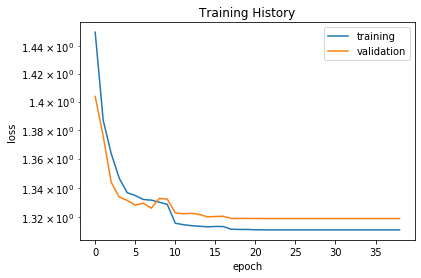

In [70]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [71]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

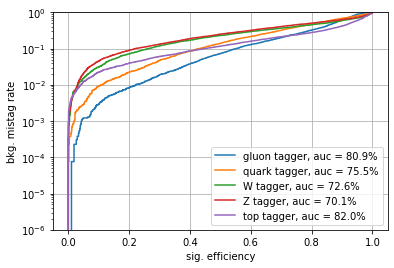

In [72]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()